## SED modelling

Demo notebook on how to generate SED for subhalo based on stellar particle information, and optionally extract reionisation parameters.

In [24]:
import numpy as np
import pickle as pcl
from bisect import bisect
from scipy.stats import binned_statistic

import astropy.units as u
from astropy.cosmology import Planck13, z_at_value

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.colorbrewer.qualitative import Set2_7

In [ ]:
import calcsed

In [2]:
c = 2.99792E8

Load Subhalo properties

In [3]:
tag = '004_z008p075' #'003_z008p988' #'005_z007p050' # 

data = pcl.load(open('subfind_output/subhalo_ids_'+tag+'.p','rb'))#, encoding='latin1')

sim_z = data['header']['simulation redshift']
sim_age = data['header']['simulation age']
h = data['header']['hubble param']

subhalos = data['data']

del(data)

Choose a single SPS model

In [4]:
models = ['BC03_Padova1994_Salpeter_lr', 'BPASSv2_imf135all_100', 'BPASSv2_imf135all_100-bin', 
          'P2_Salpeter_ng', 'M05_Salpeter_rhb', 'FSPS_default_Salpeter']

models_pretty = ['BC03','BPASS','BPASS-bin','PEGASE.2','M05','FSPS']

model = models[3]

Load SED data for that SPS model

In [5]:
data = pcl.load(open('../Input_SPS/model_pickles/'+model+'.p', 'rb'))#, encoding='latin1')
  
raw_sed = data['SED'] # ergs s^-1 Hz^-1
Z = data['metallicities']  # metallicity
ages = data['ages']  # Myr
wavelength = data['lam'] # [ microns ]
frequency = c/(wavelength*1e-6)  # [ s^-1 ]
del(data)

calculate scale factor for all ages in SED tables

In [6]:
particle_ages = sim_age - (ages * 10**-3)  # convert to age in simulation snapshot

a = []
for p in particle_ages:  # convert to scale factor (to match particle values)
    if(p > 0.0001):
        a.append(1 / (1 + (z_at_value(Planck13.age, p * u.Gyr))))
        
a = np.array(a)

filter by age values above 0

In [7]:
raw_sed = raw_sed[:,:len(a)]

### Calculate SED and $\xi_{\mathrm{ion}}$ for a single subhalo

In [19]:
subhalo = [subhalos[0]]

sed = calcsed.calculate_sed(subhalo, raw_sed, Z, a)[0] # ergs s^-1 Hz^-1 

Lnu = sed * 1e-7 / 3.828e26 # L_{\odot} Hz^-1

(1e-12, 1e-08)

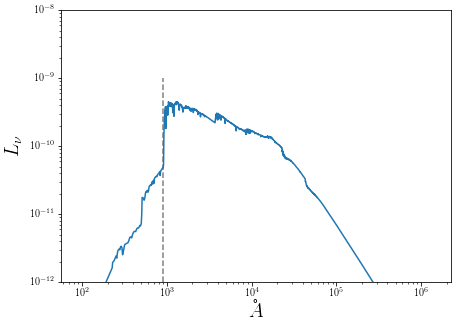

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.loglog(wavelength * 1e4, Lnu)

ax.set_xlabel('$\AA$', size=20)
ax.set_ylabel('$L_{\\nu}$', size=20)

ax.vlines(912, 1e-12, 1e-9, linestyle='dashed', color='grey')

ax.set_ylim(1e-12, 1e-8)
# ax.set_xlim(0,2.5)

Calculate $\xi_{\mathrm{ion}}$

In [10]:
calcsed.calculate_xi_ion(Lnu, frequency) # erg^-1 Hz

8.0320047530150715e+24

### Calculate $\xi_{\mathrm{ion}}$ for all subhalos

In [20]:
sed = calcsed.calculate_sed(subhalos, raw_sed, Z, a) # ergs s^-1 Hz^-1 

Lnu = [s * 1e-7 / 3.828e26 for s in sed] # L_{\odot} Hz^-1

xi_ion = [calcsed.calculate_xi_ion(lnu, frequency) for lnu in Lnu]

In [21]:
mstar = [np.log10(np.sum(subhalo['stellar mass']) * 1e6) for subhalo in subhalos]

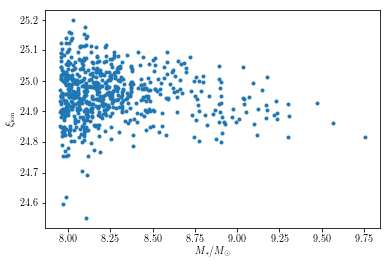

In [22]:
plt.plot(mstar, np.log10(xi_ion), '.')

plt.xlabel('$M_{*} / M_{\odot}$')
plt.ylabel('$\\xi_{\mathrm{ion}}$')

### Calculate $\xi_{\mathrm{ion}}$ for all SPS models

In [55]:
xi_ion = [[] for i in range(len(models))]

for i, model in enumerate(models):
    
    print "Model:",model
    
    data = pcl.load(open('../Input_SPS/model_pickles/'+model+'.p', 'rb'))#, encoding='latin1')
  
    raw_sed = data['SED'] # ergs s^-1 Hz^-1
    Z = data['metallicities']  # metallicity
    ages = data['ages']  # Myr
    wavelength = data['lam'] # [ microns ]
    frequency = c/(wavelength*1e-6)  # [ s^-1 ]
    del(data)
    
    particle_ages = sim_age - (ages * 10**-3)  # convert to age in simulation snapshot

    a = []
    for p in particle_ages:  # convert to scale factor (to match particle values)
        if(p > 0.0001):
            a.append(1 / (1 + (z_at_value(Planck13.age, p * u.Gyr))))

    a = np.array(a)

    raw_sed = raw_sed[:,:len(a)]
    
    sed = calcsed.calculate_sed(subhalos, raw_sed, Z, a) # ergs s^-1 Hz^-1 

    Lnu = [s * 1e-7 / 3.828e26 for s in sed] # L_{\odot} Hz^-1

    xi_ion[i] = [calcsed.calculate_xi_ion(lnu, frequency) for lnu in Lnu]
    

Model: BC03_Padova1994_Salpeter_lr
Model: BPASSv2_imf135all_100
Model: BPASSv2_imf135all_100-bin
Model: P2_Salpeter_ng
Model: M05_Salpeter_rhb
Model: FSPS_default_Salpeter


In [14]:
# pcl.dump(xi_ion, open('xi_ion.p','w'))
xi_ion = pcl.load(open('xi_ion.p','r'))

In [15]:
mstar = [np.log10(np.sum(subhalo['stellar mass']) * 1e6) for subhalo in subhalos]

In [16]:
massBinLimits = np.linspace(7.1, 11.1, 21)
massBins = np.logspace(7.2, 11.0, 20)

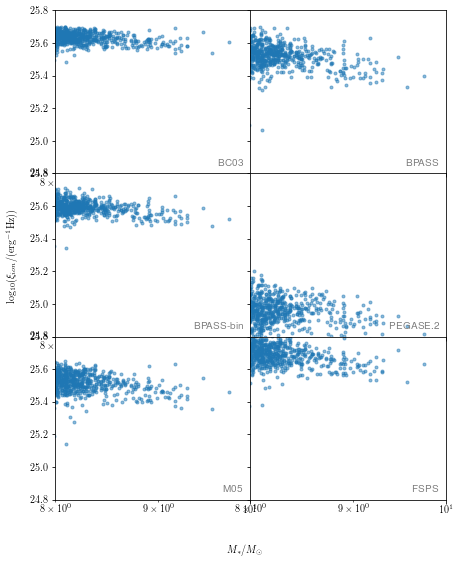

In [17]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(7,9), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

fig.text(0.5, 0.04, "$M_{*} / M_{\odot}$", ha='center')
fig.text(0.03, 0.5, "$\mathrm{log_{10}}( \\xi_{ion} / (\mathrm{erg}^{-1} \mathrm{Hz}))$", 
         va='center', rotation='vertical')

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for model, pretty, xi, ax in zip(models, models_pretty, xi_ion, axes):

    median, dump, dump = binned_statistic(mstar, xi, statistic='median', bins=10**massBinLimits)
    p16, dump, dump = binned_statistic(mstar, xi, statistic=lambda y: np.percentile(y, 16), bins=10**massBinLimits)
    p84, dump, dump = binned_statistic(mstar, xi, statistic=lambda y: np.percentile(y, 84), bins=10**massBinLimits)
    
    ax.set_xscale('log')
 
    ax.plot(mstar, np.log10(xi), '.', alpha=0.5)

    mask = massBins < 5e9
    ax.errorbar(massBins[mask], np.log10(median[mask]), 
                yerr=[np.log10(median[mask])-np.log10(p16[mask]), 
                np.log10(p84[mask])-np.log10(median[mask])], 
                linestyle='none', marker = 'o', zorder=32)
    
    ax.set_xlim(8, 10)
    ax.set_ylim(24.8,25.8)

    ax.annotate(pretty, xy=(0.96,0.05), xycoords='axes fraction', horizontalalignment='right', color='grey')
    


### Bluetides comparison

In [14]:
from bigfile import BigFile

b_data_dir = '/research/astro/highz/Simulations/BlueTides/data/'
SPS_dir = '/research/astro/highz/SPS/'
b_snap = '086'
b_z = 8.

h = 0.7

In [15]:
# Open BlueTides snapshot
# current_age = np.interp(z, redshifts, age_of_universe)

snapshot = BigFile(b_data_dir + 'PIG_' + b_snap)

In [16]:
# ----- Get stellar masses
stellar_masses = snapshot['FOFGroups/MassByType'][:][:,4]/h * 1E10

In [17]:
stellar_masses.shape

(200062344,)

In [ ]:
a = snapshot['4/StarFormationTime'][sel]

ages = current_age - np.interp(a, scale_factors[::-1], age_of_universe[::-1])

metallicities = snapshot['4/Metallicity'][sel]

MetSurfaceDensity = snapshot['4/MetSurfaceDensity'][sel]

### ! Deprecated 

In [ ]:
## ---- 2D histogram

xbins = 10**np.linspace(8, 10, 20)
ybins = np.linspace(25, 26, 15)

counts, xedges, yedges = np.histogram2d(mass, np.log10(xi_ion), bins=([xbins, ybins]))

extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]

fig, ax = plt.subplots()
#ax.pcolormesh(xbins, ybins, counts.T)

levels = (1e1, 3e1, 1e2, 2e2)
cset = contour(counts.T, levels, origin='lower', colors=['black', 'green', 'blue', 'red'], linewidths=(1.9, 1.6, 1.5, 1.4), extent=extent)

#plt.clabel(cset, inline=1, fontsize=10, fmt='%1.0i')

for c in cset.collections:
    c.set_linestyle('solid')

    ax.set_xscale('log')
 
    plt.show()

In [ ]:
### xi_ion as a function of age
fig, axes = plt.subplots(3,2,sharex='col', sharey='row')

fig.text(0.5, 0.04, r"$log_{10}$(age)", ha='center')
fig.text(0.03, 0.5, r"$log_{10}(\xi_{ion})$", ha='center', rotation='vertical')

for m,ax in zip(models,axes.flatten()):

    data = pcl.load(open('../Input_SPS/model_pickles/'+m+'.p', 'rb'))#, encoding='latin1')

    sed = data['SED'] # erg cm^-2 s^-1
    Z = data['metallicities']  # metallicity
    ages = data['ages']  # Myr
    wavelength = data['lam']  # [ AA ]
    frequency = c/(wavelength*1E-6)  # [ s^-1 ]
        
    # sum sed values for a given metallicity / age
    
    xi_ion = np.zeros(sed.shape[1])
    
    for j in xrange(sed.shape[0]):
        for i in xrange(sed.shape[1]): 
            xi_ion[i] = np.log10(calculate_xi_ion(sed[j,i],frequency,1e9))
        
        ax.plot(np.log10(ages),xi_ion)

    ax.annotate(m,xy=(-1,min(xi_ion)))
